# Setup

[LSTM Music Generation Tutorial Series](https://youtube.com/playlist?list=PL-wATfeyAMNr0KMutwtbeDCmpwvtul-Xz)

In [ ]:
!pip install music21
!pip install numpy
!pip install tensorflow
!pip install keras
!pip install matplotlib
!apt install fluidsynth #Pip does not work for some reason. Only apt works
!pip install midi2audio
!apt-get install musescore3

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fluidsynth is already the newest version (2.2.5-1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
musescore3 is already the newest version (3.2.3+dfsg2-11).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [ ]:
import os
import json
import music21 as m21
import numpy as np
import keras
import matplotlib.pyplot as plt
from tqdm import tqdm
from midi2audio import FluidSynth
from IPython.display import Audio, display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data source: http://www.esac-data.org

In [ ]:
kern_dataset_path = "/content/drive/MyDrive/MusicGeneration/LSTM/raw_dataset/deutschl/test"
preprocessed_dataset_path = "/content/drive/MyDrive/MusicGeneration/LSTM/preprocessed_dataset"
final_dataset_path = "/content/drive/MyDrive/MusicGeneration/LSTM/final_dataset"
mapping_path = "/content/drive/MyDrive/MusicGeneration/LSTM/mapping.json"
save_model_path = "/content/drive/MyDrive/MusicGeneration/LSTM/model.h5"
save_melody_path = "/content/drive/MyDrive/MusicGeneration/LSTM/melody.mid"

In [ ]:
sequence_length = 64
new_song_delimiter = "/ " * sequence_length
num_units = 256
loss = "sparse_categorical_crossentropy"
learning_rate = 0.001
epochs = 50
batch_size = 64

In [ ]:
# durations are expressed in quarter length
acceptable_durations = [
    0.25, # 16th note
    0.5, # 8th note
    0.75,
    1.0, # quarter note
    1.5,
    2, # half note
    3,
    4 # whole note
]

# Preprocess

In [ ]:
def load_songs_in_kern(dataset_path):
    """Loads all kern pieces in dataset using music21.

    :param dataset_path (str): Path to dataset
    :return songs (list of m21 streams): List containing all pieces
    """
    songs = []

    # go through all the files in dataset and load them with music21
    for path, subdirs, files in os.walk(dataset_path):
        for file in tqdm(files):
            # Last 3 characters (file extension) are krn (kern files)
            if file[-3:] == "krn":
                song = m21.converter.parse(os.path.join(path, file))
                songs.append(song)
    return songs

In [ ]:
def has_acceptable_durations(song, acceptable_durations):
    """Boolean routine that returns True if piece has all acceptable duration, False otherwise.

    :param song (m21 stream):
    :param acceptable_durations (list): List of acceptable duration in quarter length
    :return (bool):
    """
    for note in song.flat.notesAndRests:
        if note.duration.quarterLength not in acceptable_durations:
            return False
    return True

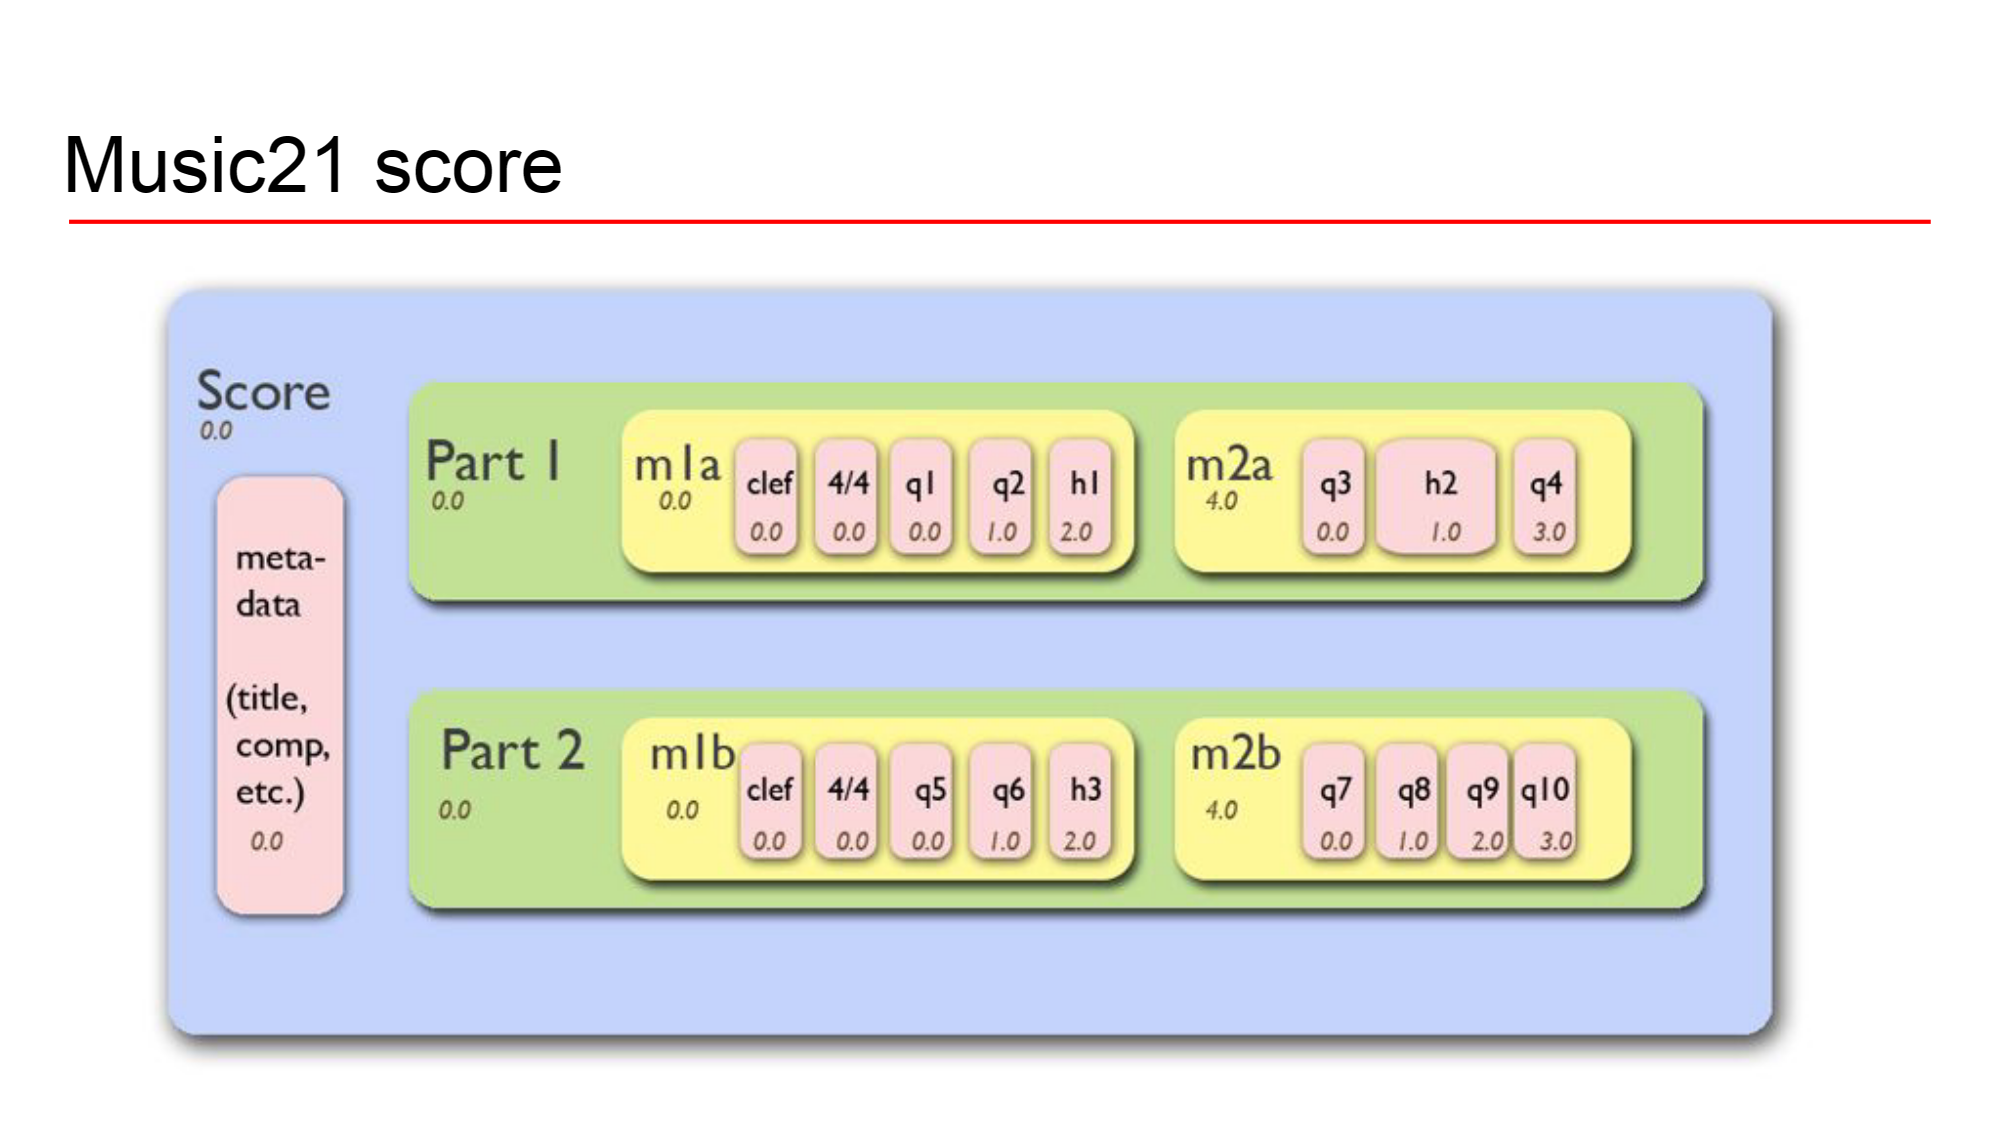

There are 24 keys (tone) = 12 tonics (major, maybe C, C#,...) x 2 modes (major and minor)
1. https://en.wikipedia.org/wiki/%C4%90i%E1%BB%87u_t%C3%ADnh
2. https://hellomusictheory.com/learn/keys/
3. https://learningmusic.ableton.com/en/notes-and-scales/keys-and-scales.html

In [ ]:
# Transposes song to C maj/A min
def transpose(song):
    parts = song.getElementsByClass(m21.stream.Part)
    measures_part0 = parts[0].getElementsByClass(m21.stream.Measure)
    key = measures_part0[0][4] # Get key from first measure (bar) of first part of score.

    if not isinstance(key, m21.key.Key): # if variable "key" is not an instance of m21.key.Key (there is no key in the song)
        key = song.analyze("key") # estimate key using music21

    # get interval for transposition. Example: B major -> C major
    if key.mode == "major":
        interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch("C"))
    elif key.mode == "minor":
        interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch("A"))

    # transpose other keys to keys of C Major or A Minor to reduce data complexity
    tranposed_song = song.transpose(interval)
    return tranposed_song

In [ ]:
def encode_song(song, time_step=0.25):
    """Converts a score to a time-series representation. Each symbol in the encoded list represents a quarter-length note/rest.
    The symbols include: integer for MIDI notes, 'r' for a rest, and '_' for repeating previous notes/rest.
    Here's a sample encoding: ["r", "_", "60", "_", "_", "_"]
    Rest 0.5 beats, a quarter note C (1 beat)
    """

    encoded_song = []

    for event in song.flat.notesAndRests:

        # handle notes
        if isinstance(event, m21.note.Note):
            symbol = event.pitch.midi # 60
        # handle rests
        elif isinstance(event, m21.note.Rest):
            symbol = "r"

        # convert the note/rest into time series notation
        steps = int(event.duration.quarterLength / time_step) # Example: steps = half note / time_step = 2 / 0.5 = 8
        for step in range(steps):

            # if it's the first time we see a note/rest, let's encode it. Otherwise, it means we're carrying the same
            # symbol in a new time step
            if step == 0:
                encoded_song.append(symbol)
            else:
                encoded_song.append("_")

    # cast encoded song to str
    encoded_song = " ".join(map(str, encoded_song))

    return encoded_song

In [ ]:
def preprocess(dataset_path):
    # load folk songs
    print("Loading songs...")
    songs = load_songs_in_kern(dataset_path)

    print("Preprocessing songs...")
    for i, song in enumerate(tqdm(songs)):

        # filter out songs that have non-acceptable durations
        if not has_acceptable_durations(song, acceptable_durations):
            continue

        # song.show() # Open original song in MuseScore
        song = transpose(song) # transpose songs to Cmaj/Amin
        # song.show() # Open encoded song in MuseScore

        # encode songs with music time series representation
        encoded_song = encode_song(song)

        # save songs to text file
        save_path = os.path.join(preprocessed_dataset_path, str(i))
        with open(save_path, "w") as fp:
            fp.write(encoded_song)

In [ ]:
def load(file_path):
    with open(file_path, "r") as fp:
        song = fp.read()
    return song

In [ ]:
def create_single_file_dataset(dataset_path, file_dataset_path, sequence_length):
    """Generates a file collating all the encoded songs and adding new piece delimiters.

    :param dataset_path (str): Path to folder containing the encoded songs
    :param file_dataset_path (str): Path to file for saving songs in single file
    :param sequence_length (int): # of time steps to be considered for training
    :return songs (str): String containing all songs in dataset + delimiters
    """

    songs = ""

    # add all encoded songs to string and add delimiters between them
    for path, _, files in os.walk(dataset_path):
        for file in files:
            file_path = os.path.join(path, file)
            song = load(file_path)
            songs = songs + song + " " + new_song_delimiter

    # remove empty space from last character of string
    songs = songs[:-1]

    # save string that contains all the dataset
    with open(file_dataset_path, "w") as fp:
        fp.write(songs)

    return songs

In [ ]:
def create_mapping(songs, mapping_path):
    """Creates a json file that maps the symbols in the song dataset onto integers

    :param songs (str): String with all songs
    :param mapping_path (str): Path where to save mapping
    :return:
    """
    dictionary = {}

    # identify set of unique notes
    songs = songs.split()
    unique_notes = list(set(songs))
    print("Set of unique notes:", unique_notes[:])

    print("Mapping songs...")
    for i, symbol in enumerate(tqdm(unique_notes)):
        dictionary[symbol] = i # Map each note (key) with a unique number (value) to a dictionary

    # save dictionary to a json file
    with open(mapping_path, "w") as fp:
        json.dump(dictionary, fp, indent=4)
    print("Saved dictionary at",mapping_path)

    return unique_notes

In [ ]:
def convert_songs_to_int(songs):
    int_songs = []

    # load mappings
    with open(mapping_path, "r") as fp:
        mappings = json.load(fp)

    # transform songs string to list
    songs = songs.split()

    # map songs to int
    for symbol in songs:
        int_songs.append(mappings[symbol])

    return int_songs

In [ ]:
def generate_training_sequences(sequence_length, dictionary_size):
    """Create input and output data samples for training. Each sample is a sequence.

    :param sequence_length (int): Length of each sequence. With a quantisation at 16th notes, 64 notes equates to 4 bars

    :return inputs (ndarray): Training inputs
    :return targets (ndarray): Training targets
    """

    # load songs and map them to int
    songs = load(final_dataset_path)
    int_songs = convert_songs_to_int(songs)

    inputs = []
    targets = []

    # generate the training sequences
    num_sequences = len(int_songs) - sequence_length

    # A target note is predicted from the input notes
    print("Generating sequences for training...")
    for i in tqdm(range(num_sequences)):
        inputs.append(int_songs[i:i+sequence_length])
        targets.append(int_songs[i+sequence_length])
    """
    Example: int_song = [1,3,2,5,3], sequence_length = 3
    num_sequences = len(int_songs) - sequence_length = 5 - 3 = 2
    for i in range(2):
      i = 0:
        inputs[0] = int_song[0:3] = 1,3,2
        targets[0] = int_song[3] = 5
      i = 1:
        inputs[1] = int_song[1:4]= 3,2,5
        targets[1] = int_song[4] = 3
    """

    # one-hot encode the sequences
    inputs = keras.utils.to_categorical(inputs, num_classes=dictionary_size)
    """
    keras.utils.to_categorical: convert lists of integers to one-hot numpy arrays.
    In these arrays there is only one element = 1 and all other elements = 0.
    Example: [[3],[5],...] -> [[0,1,0,0],[0,0,1,0],...]
    """
    targets = np.array(targets)
    #Loss function "sparse categorical crossentropy" allows us to directly use the integer labels without one-hot encoding

    # print(f"There are {len(inputs)} sequences.")

    return inputs, targets

In [ ]:
preprocess(kern_dataset_path)
songs = create_single_file_dataset(preprocessed_dataset_path, final_dataset_path, sequence_length)
dictionary = create_mapping(songs, mapping_path)
inputs, targets = generate_training_sequences(sequence_length, len(dictionary))

Loading songs...


100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


Preprocessing songs...


100%|██████████| 12/12 [00:05<00:00,  2.10it/s]


Set of unique notes: ['74', '66', '53', '71', '56', '69', '62', '57', '65', '77', '/', '55', '58', '59', '61', '48', '63', '50', '72', '76', '68', 'r', '60', '_', '47', '64', '52', '81', '54', '67']
Mapping songs...


100%|██████████| 30/30 [00:00<00:00, 87018.76it/s]


Saved dictionary at /content/drive/MyDrive/MusicGeneration/LSTM/mapping.json
Generating sequences for training...


100%|██████████| 48102/48102 [00:00<00:00, 125557.79it/s]


# Train

In [ ]:
def build_model(output_units, num_units, loss, learning_rate):
    # create the model architecture
    input = keras.layers.Input(shape=(None, output_units))
    # x = keras.layers.LSTM(num_units[0])(input) # For CPU
    x = keras.layers.Bidirectional(keras.layers.CuDNNLSTM(num_units))(input) # For GPU
    x = keras.layers.Dropout(0.2)(x)

    output = keras.layers.Dense(output_units, activation="softmax")(x)

    model = keras.Model(input, output)

    # compile model
    model.compile(loss=loss,
                  optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    model.summary()

    return model

In [ ]:
# build the network
model = build_model(len(dictionary), num_units, loss, learning_rate)

# train the model
es = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5) # https://keras.io/api/callbacks/early_stopping/
history = model.fit(inputs, targets, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[es])

# save the model
model.save(save_model_path)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 30)]        0         
                                                                 
 bidirectional (Bidirectiona  (None, 512)              589824    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 30)                15390     
                                                                 
Total params: 605,214
Trainable params: 605,214
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
677/677 [==============================] - 16s 13ms/step - loss: 0.8615 - accuracy: 0.7524 - val_loss: 0.8877 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


<ipython-input-23-c47e7c3ee149>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1) # 1 rows, 2 cols, index 1


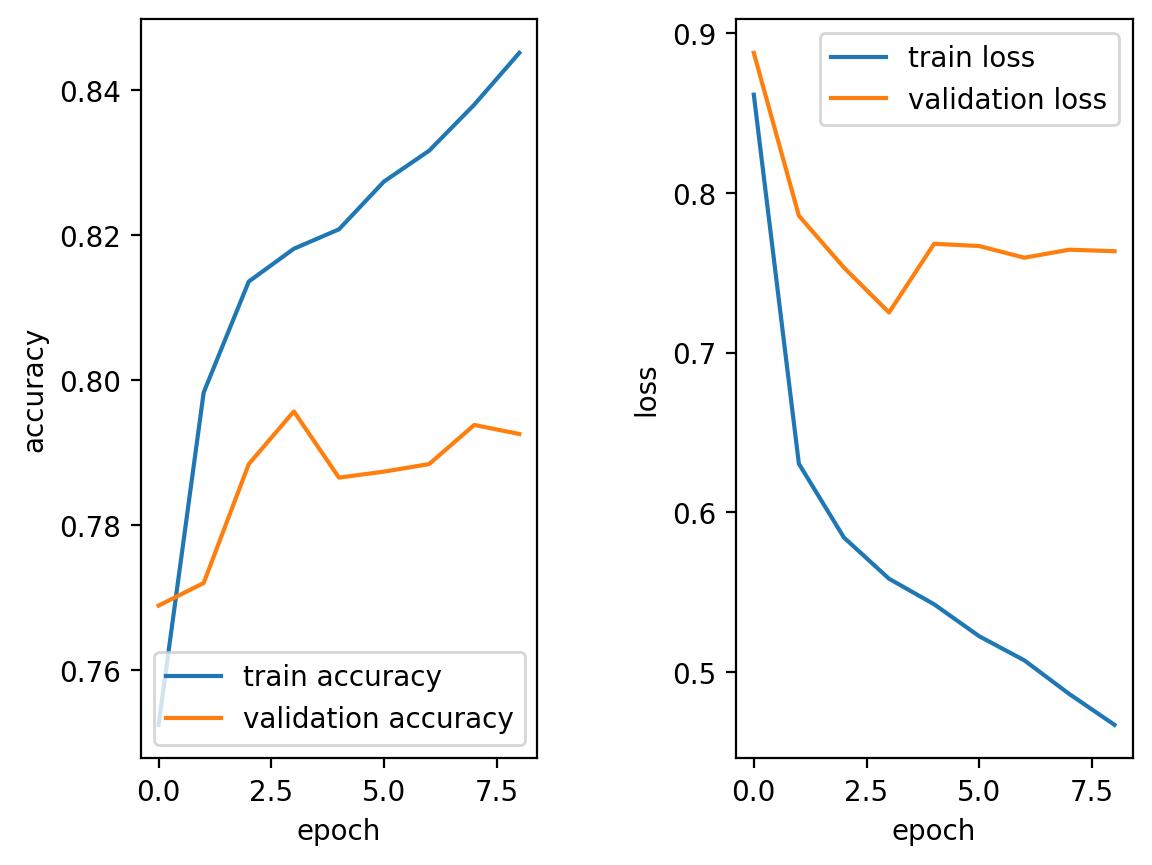

In [ ]:
# statistics
print(history.history.keys())

plt.title("Model training and validation statistics")

plt.subplot(1,2,1) # 1 rows, 2 cols, index 1
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train accuracy', 'validation accuracy'], loc = 'best') # loc: location
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.subplot(1,2,2) # 1 rows, 2 cols, index 2
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train loss', 'validation loss'])
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

# Generate

In [ ]:
def generate_melody(seed, max_sequence_length, song_length, num_classes):
  melody = seed.split()
  seed = convert_songs_to_int(seed)
  model = keras.models.load_model(save_model_path)
  """
  Example: seed = [44, 50, 64, 73], max_sequence_length = 3.
  seed[-max_sequence_length:] = seed[-3:] = [50, 64, 73]
  seed.append(67) -> seed = [50, 64, 73, 67]
  seed[-3:] = [64, 73, 67].
  """
  for _ in range(song_length):
    seed = seed[-max_sequence_length:] # Example: seed[-10:] means get the last 10 elements
    onehot_seed = keras.utils.to_categorical(seed, num_classes=num_classes) # one-hot encode the sequences

    onehot_seed = onehot_seed[np.newaxis,...]  # add new axis to onehot_seed matrix. shape = (64, 28) -> (1, 64, 28)
    """ Because Keras expects a batch of samples, so we have to use 3-dimensional array although there is only one 2-dimensional element.
    Example: [[1, 3],[2, 4]] -> [[[1, 3],[2, 4]]]."""

    probabilitites = model.predict(onehot_seed)[0]
    """ Returns a matrix that includes the probability for each music symbol.
    Example: prob = [[0.1, 0.2]] -> Remove new axis with prob[0] = [0.1, 0.2]"""

    max_probability = max(probabilitites) # get the max probability
    max_probability_index = probabilitites.argmax() # get the index of max probability
    predicted_symbol = dictionary[max_probability_index]
    print("Predicted symbol:", predicted_symbol, "\nProbability:", max_probability)

    seed.append(max_probability_index)

    if predicted_symbol == "/":
      break

    melody.append(predicted_symbol)
    # print(melody)

  return melody

> **One-hot encoded seed**


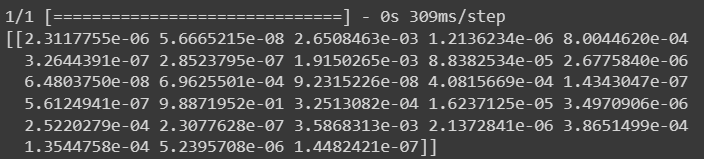

In [ ]:
def save_melody(melody, save_melody_path, step_duration=0.25, format="midi"):
  stream = m21.stream.Stream()

  pre_symbol = None
  step_counter = 1

  for i, symbol in enumerate(melody):

    if symbol == "_" and i + 1 < len(melody):
        step_counter += 1

    else:
      if pre_symbol is not None:
        quarter_length = step_duration * step_counter # Example: ["60", "_", "_", "_"] -> quarter_length = 0.25 * 4 = 1 (a quarter note C)

        if pre_symbol == "r":
          m21_event = m21.note.Rest(quarterLength = quarter_length)
        else:
          m21_event = m21.note.Note(int(pre_symbol), quarterLength = quarter_length)

        stream.append(m21_event)
        step_counter = 1

      pre_symbol = symbol

  stream.write(format, save_melody_path)
  print("\nMelody sheet:\n")
  stream.show()

In [ ]:
def play_melody(melody_path):
  FluidSynth("/usr/share/sounds/sf2/FluidR3_GM.sf2", 16000).midi_to_audio(melody_path, melody_path[:-3] + 'wav')
  print("\nPlay melody.wav:\n")
  display(Audio(str(melody_path[:-3] + 'wav'), rate=16000))

Seed song:  67 _ 67 _ 67 _ _ 65 64 _ 64 _ 64 _ _
Song length (100 < x < 1000): 200
1/1 [==============================] - 0s 248ms/step
Predicted symbol: _ 
Probability: 0.8379734
1/1 [==============================] - 0s 247ms/step
Predicted symbol: 62 
Probability: 0.38963556
1/1 [==============================] - 0s 23ms/step
Predicted symbol: _ 
Probability: 0.99562645
1/1 [==============================] - 0s 20ms/step
Predicted symbol: 62 
Probability: 0.48880982
1/1 [==============================] - 0s 21ms/step
Predicted symbol: _ 
Probability: 0.9861872
1/1 [==============================] - 0s 18ms/step
Predicted symbol: 62 
Probability: 0.4049963
1/1 [==============================] - 0s 19ms/step
Predicted symbol: _ 
Probability: 0.9940148
1/1 [==============================] - 0s 20ms/step
Predicted symbol: _ 
Probability: 0.41346553
1/1 [==============================] - 0s 24ms/step
Predicted symbol: _ 
Probability: 0.9039667
1/1 [==============================] - 0s 24

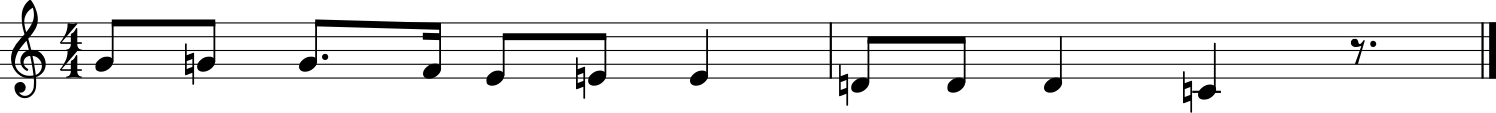


Play melody.wav:



In [ ]:
seed = "67 _ 67 _ 67 _ _ 65 64 _ 64 _ 64 _ _"
# seed = ""
# pitch_list = "r(Rest), "

# for x in dictionary:
#   if x.isdigit():
#     pitch_list += x + "(" + m21.note.Note(int(x)).nameWithOctave  + "), "

# duration_list = ", ".join(map(str, ACCEPTABLE_DURATIONS))

# n = int(input("Number of notes: "))
# for i in range(n):
#   seed += input("Pitch of note [{}]:\n".format(pitch_list)) + " "
#   duration = float(input("Duration of note [{}]: ".format(duration_list)))

#   if duration > 0.25:
#     for i in range(int(duration/0.25)):
#       seed += "_ "

print("Seed song: ", seed)

song_length = int(input("Song length (100 < x < 1000): "))
melody = generate_melody(seed, sequence_length, song_length, len(dictionary))
print("\nMelody symbols:", melody)

save_melody(melody, save_melody_path)
play_melody(save_melody_path)